# Crowd Counting Using Gaussian-Density Maps

In [30]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sys
from PIL import Image
import os
import random
from keras.applications import VGG16
import h5py
import glob
from tqdm import tqdm
from scipy.ndimage.filters import gaussian_filter
import cv2
import scipy
import scipy.io as io
import json
from matplotlib import cm
from keras import backend as K
from sklearn.metrics import mean_absolute_error
from scipy import spatial
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import model_from_json

# Path to All Files

In [11]:
part_a_train = '/kaggle/input/shanghaitech-with-people-density-map/shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/images'
part_a_test = '/kaggle/input/shanghaitech-with-people-density-map/shanghaitech_with_people_density_map/ShanghaiTech/part_A/test_data/images'
part_b_train = '/kaggle/input/shanghaitech-with-people-density-map/shanghaitech_with_people_density_map/ShanghaiTech/part_B/train_data/images'
part_b_test = '/kaggle/input/shanghaitech-with-people-density-map/shanghaitech_with_people_density_map/ShanghaiTech/part_B/test_data/images'

trainPath=[part_a_train,part_b_train]
testPath=[part_a_test,part_b_test]

# Images Path

In [12]:
train=[]
test=[]

for path in trainPath:
    for image_path in glob.glob(os.path.join(path,'*.jpg')):
        train.append(image_path)

for path in testPath:
    for image_path in glob.glob(os.path.join(path,'*.jpg')):
        test.append(image_path)

print(len(train))
print(len(test))

700
498


In [13]:
train[:5]

['/kaggle/input/shanghaitech-with-people-density-map/shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/images/IMG_160.jpg',
 '/kaggle/input/shanghaitech-with-people-density-map/shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/images/IMG_233.jpg',
 '/kaggle/input/shanghaitech-with-people-density-map/shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/images/IMG_21.jpg',
 '/kaggle/input/shanghaitech-with-people-density-map/shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/images/IMG_289.jpg',
 '/kaggle/input/shanghaitech-with-people-density-map/shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/images/IMG_163.jpg']

In [14]:
test[0:5]

['/kaggle/input/shanghaitech-with-people-density-map/shanghaitech_with_people_density_map/ShanghaiTech/part_A/test_data/images/IMG_160.jpg',
 '/kaggle/input/shanghaitech-with-people-density-map/shanghaitech_with_people_density_map/ShanghaiTech/part_A/test_data/images/IMG_21.jpg',
 '/kaggle/input/shanghaitech-with-people-density-map/shanghaitech_with_people_density_map/ShanghaiTech/part_A/test_data/images/IMG_163.jpg',
 '/kaggle/input/shanghaitech-with-people-density-map/shanghaitech_with_people_density_map/ShanghaiTech/part_A/test_data/images/IMG_151.jpg',
 '/kaggle/input/shanghaitech-with-people-density-map/shanghaitech_with_people_density_map/ShanghaiTech/part_A/test_data/images/IMG_166.jpg']

# Plotting Image

In [15]:
def plotInputImage(image):
    plt.figure()
    plt.imshow(image)

def plotOutputImage(image):
    plt.figure()
    plt.imshow(image,cmap=cm.jet)

# Utility Functions 

In [16]:
def getOutputPath(inputPath):
    outputPath=inputPath.replace('.jpg','.h5').replace('images','ground-truth-h5')
    return outputPath

def loadInputImage(path):
    image=Image.open(path).convert('RGB')
    image=np.array(image)/255.0
    return image

def loadOutputImage(path):
    file=h5py.File(path,'r')
    image=np.asarray(file['density'])
    # As suggested in the paper the output dimensions are 1/8th the size of original image
    image=cv2.resize(image,(int(image.shape[1]/8),int(image.shape[0]/8)),interpolation=cv2.INTER_CUBIC)*64
    return image
    
def horizontalFlipInput(path):
    image=loadInputImage(path)
    image=np.fliplr(image)
    return image

def verticalFlipInput(path):
    image=loadInputImage(path)
    image=np.flipud(image)
    return image

def horizontalFlipOutput(path):
    image=loadOutputImage(path)
    image=np.fliplr(image)
    return image

def verticalFlipOutput(path):
    image=loadOutputImage(path)
    image=np.flipud(image)
    return image

# Plotting Random Images

In [17]:
randomIndex=random.randint(0,200)
randomIndex

179

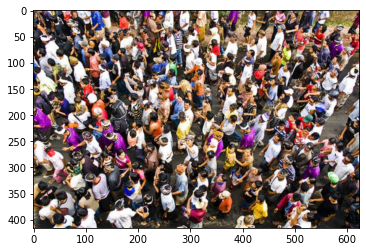

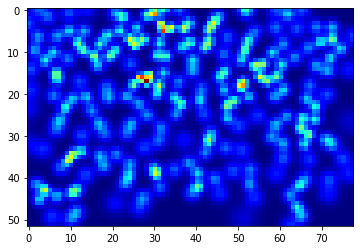

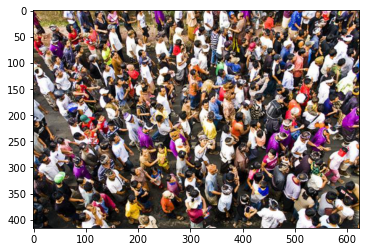

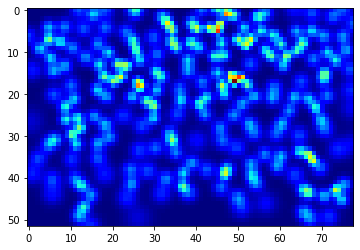

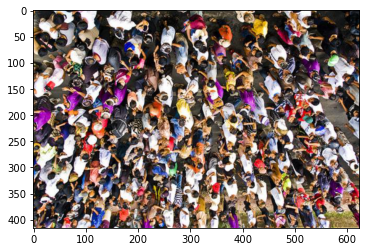

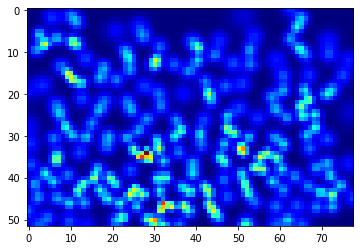

In [18]:
plotInputImage(loadInputImage(train[randomIndex]))
plotOutputImage(loadOutputImage(getOutputPath(train[randomIndex])))

plotInputImage(horizontalFlipInput(train[randomIndex]))
plotOutputImage(horizontalFlipOutput(getOutputPath(train[randomIndex])))

plotInputImage(verticalFlipInput(train[randomIndex]))
plotOutputImage(verticalFlipOutput(getOutputPath(train[randomIndex])))

# Image Data Generator Function

In [19]:
def dataGenerator(files):
    index=0
    l=len(files)
    
    while True:
        index=(index+1)%l
        
        inputPath=files[index]
        outputPath=getOutputPath(inputPath)
            
        x=[]
        y=[]
        
        x.append(loadInputImage(inputPath))
        y.append(loadOutputImage(outputPath))
        
        x.append(horizontalFlipInput(inputPath))
        y.append(horizontalFlipOutput(outputPath))
        
        x.append(verticalFlipInput(inputPath))
        y.append(verticalFlipOutput(outputPath))
        
        x=np.array(x)
        y=np.array(y)
        
        yield (x,y)

# Mean Squared Error

In [20]:
# Loss function as mentioned in paper
def meanSquareRootError(yTrue, yPred):
    return K.sqrt(K.sum(K.square(yTrue-yPred),axis=-1))

# Initialize The Input Layers with VGG16

In [21]:
def initializeVGGLayers(model):
    vgg=VGG16(weights='imagenet')
    weights=[]
    
    for layer in vgg.layers:
        if 'conv' in layer.name:
            weights.append(layer.get_weights())
    
    ind=0
    for i in range(0,len(model.layers)):
        # Only 1st 10 layers of VGG16 are used
        if ind>9:
            break
        if 'conv' in model.layers[i].name:
            model.layers[i].set_weights(weights[ind])
            ind+=1
    
    return model

# Creating CSR-Net Inspired Neural Network

In [22]:
def createModel():
    
    # As mentioned in paper the image input size is Unfixed
    rows=None
    cols=None
    
    vggKernel=(3,3)
    alphaRate=0.05
    
    model=Sequential()
    
    model.add(Conv2D(64,kernel_size=vggKernel,activation=LeakyReLU(alpha=alphaRate),padding='same',input_shape=(rows,cols,3)))
    model.add(Conv2D(64,kernel_size=vggKernel,activation=LeakyReLU(alpha=alphaRate),padding='same'))
    model.add(MaxPooling2D(strides=2))
    
    model.add(Conv2D(128,kernel_size=vggKernel,activation=LeakyReLU(alpha=alphaRate),padding='same'))
    model.add(Conv2D(128,kernel_size=vggKernel,activation=LeakyReLU(alpha=alphaRate),padding='same'))
    model.add(MaxPooling2D(strides=2))
    
    model.add(Conv2D(256,kernel_size=vggKernel,activation=LeakyReLU(alpha=alphaRate),padding='same'))
    model.add(Conv2D(256,kernel_size=vggKernel,activation=LeakyReLU(alpha=alphaRate),padding='same'))
    model.add(Conv2D(256,kernel_size=vggKernel,activation=LeakyReLU(alpha=alphaRate),padding='same'))
    model.add(MaxPooling2D(strides=2))            
    
    model.add(Conv2D(512,kernel_size =vggKernel,activation=LeakyReLU(alpha=alphaRate),padding='same'))
    model.add(Conv2D(512,kernel_size =vggKernel,activation=LeakyReLU(alpha=alphaRate),padding='same'))
    model.add(Conv2D(512,kernel_size =vggKernel,activation=LeakyReLU(alpha=alphaRate),padding='same'))
    
    # Custom Layers proposed in paper
    model.add(Conv2D(512,(3,3),activation=LeakyReLU(alpha=alphaRate),dilation_rate=2,padding = 'same'))
    model.add(Conv2D(512,(3,3),activation=LeakyReLU(alpha=alphaRate),dilation_rate=2,padding = 'same'))
    model.add(Conv2D(512,(3,3),activation=LeakyReLU(alpha=alphaRate),dilation_rate=2,padding = 'same'))
    
    model.add(Conv2D(256,(3,3),activation=LeakyReLU(alpha=alphaRate),dilation_rate=2,padding = 'same'))
    
    model.add(Conv2D(128,(3,3),activation=LeakyReLU(alpha=alphaRate),dilation_rate=2,padding = 'same'))
    
    model.add(Conv2D(64,(3,3),activation=LeakyReLU(alpha=alphaRate),dilation_rate=2,padding = 'same'))
    
    model.add(Conv2D(1, (1, 1),activation=LeakyReLU(alpha=alphaRate),dilation_rate=1,padding = 'same'))
    
    model.compile(optimizer='adam',loss=meanSquareRootError,metrics=['mse'])
    
    model=initializeVGGLayers(model)
    
    return model

# Callbacks

In [23]:
checkpoint=ModelCheckpoint(filepath='crowd-counting.hdf5',monitor='val_loss',verbose=1,save_best_only=True,mode='min')
earlyStopper=EarlyStopping(monitor='val_loss',mode='min',patience=5)
callbacks=[checkpoint,earlyStopper]
trainDataGen=dataGenerator(train)
model=createModel()
model.summary()

553467904/553467096 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 64)    1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 64)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 128)   73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 128)   147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 128)   0         
_______________________________________________________

# Training The Network

In [30]:
model.fit_generator(generator=trainDataGen,epochs=20,
                    steps_per_epoch=len(train),
                    callbacks=callbacks,verbose=1)
model.save_weights('crowd-counting.hdf5')

Epoch 1/20
  7/700 [..............................] - ETA: 36:00 - loss: 74.2219 - mse: 91.5067

KeyboardInterrupt: 

# Testing

In [34]:
model.load_weights('/kaggle/input/model-wts/crowd-counting.hdf5')

In [37]:
name=[]
yTrue=[]
yPred=[]

for path in test:
    name.append(path)
    
    # Count Predicted By Model
    inputImage=loadInputImage(path)
    inputImage=inputImage.reshape(1,inputImage.shape[0],inputImage.shape[1],inputImage.shape[2])
    countPred=np.sum(model.predict(inputImage))
    yPred.append(countPred)
    
    # Counte By HeatMap
    outputPath=getOutputPath(path)
    outputImage=h5py.File(outputPath,'r')
    outputImage=np.asarray(outputImage['density'])
    countTrue=np.sum(outputImage)
    yTrue.append(int(countTrue)+1)
    
data=pd.DataFrame({'name':name,'yPred':yPred,'yTrue': yTrue})
data.to_csv('test_res.csv',sep=',')

# Performance Of Model

In [36]:
data=pd.read_csv('test_res.csv')
yTrue=data['yTrue']
yPred = data['yPred']
ans=mean_absolute_error(np.array(yTrue),np.array(yPred))
print(ans)

185.48770910669043
